In [97]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string  
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier 
import matplotlib.pyplot as plt  
import seaborn as sns 
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Dataset :

In [2]:
df=pd.read_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\healthcare_reviews\Dataset.csv')

In [3]:
# df['Sentiment'] = '0'
df.loc[df['Rating'] >3, 'Sentiment'] = '1'
df.loc[df['Rating'] ==3, 'Sentiment'] = '0'
df.loc[df['Rating'] <3, 'Sentiment'] = '-1'

In [4]:
df.head()

,Review_Text,Rating,Sentiment
0,I have mixed feelings about my experience.,4,1
1,The staff was caring and attentive. I couldn't...,5,1
2,I have mixed feelings about my experience.,5,1
3,I have mixed feelings about my experience.,5,1
4,The healthcare provider was excellent. I had a...,3,0


In [5]:
df.to_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\healthcare_reviews\Dataset_with_Sentiment.csv',index=False)

## Data Cleaning :

In [6]:
df.isnull().sum()

Review_Text    100
Rating           0
Sentiment        0
dtype: int64

In [7]:
df.shape

(1000, 3)

In [8]:
# Handling of null values
df=df.dropna()
df.shape

(900, 3)

In [9]:
# 1) Lowering of data
df['Review_Text']=df['Review_Text'].str.lower()

In [10]:
# 2) Tokenization of data
df['tokenized_reviews'] = df.apply(lambda row: nltk.word_tokenize(row['Review_Text']), axis=1)

In [11]:
# 3) Stop Words Removal in data
english_stopwords=stopwords.words('english')
custom_words_to_retain=['nor', 'not', "don't", 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

def remove_stop_words(words_list):
    return [t for t in words_list if t not in english_stopwords or t in custom_words_to_retain]

In [12]:
df['stopwords_removed']=df.apply(lambda row:remove_stop_words(row['tokenized_reviews']),axis=1)

In [13]:
# 4) Punctuations Removal in data
punctuations = string.punctuation
def remove_punct(words_list):
    return [t for t in words_list if t not in punctuations]

In [14]:
df['punct_removed']=df.apply(lambda row:remove_punct(row['stopwords_removed']),axis=1)

In [15]:
unknown=["'m","wo"]
def remove_unknown_words(words_list):
    return [t for t in words_list if t not in unknown]

In [16]:
df['punct_removed']=df.apply(lambda row:remove_unknown_words(row['punct_removed']),axis=1)

In [17]:
def find_and_replace(words_list):
    return [t.replace("n't",'not') for t in words_list]

In [18]:
df['punct_removed']=df.apply(lambda row:find_and_replace(row['punct_removed']),axis=1)

In [19]:
# df.to_csv('temp_dataset.csv',index=False)

In [20]:
# 5) Lemmatization
lm=WordNetLemmatizer()
def lemmatize_list(words_list):
    return [lm.lemmatize(t) for t in words_list]

In [21]:
df['lemmatized']=df.apply(lambda row:lemmatize_list(row['punct_removed']),axis=1)

In [22]:
# 6) Convert list to string - lemmatized column
def convert_to_string(words_list):
    return " ".join(words_list)

In [23]:
df['cleaned']=df.apply(lambda row:convert_to_string(row['lemmatized']),axis=1)

In [24]:
df.head()

,Review_Text,Rating,Sentiment,tokenized_reviews,stopwords_removed,punct_removed,lemmatized,cleaned
0,i have mixed feelings about my experience.,4,1,"[i, have, mixed, feelings, about, my, experien...","[mixed, feelings, experience, .]","[mixed, feelings, experience]","[mixed, feeling, experience]",mixed feeling experience
1,the staff was caring and attentive. i couldn't...,5,1,"[the, staff, was, caring, and, attentive, ., i...","[staff, caring, attentive, ., could, n't, happ...","[staff, caring, attentive, could, not, happier]","[staff, caring, attentive, could, not, happier]",staff caring attentive could not happier
2,i have mixed feelings about my experience.,5,1,"[i, have, mixed, feelings, about, my, experien...","[mixed, feelings, experience, .]","[mixed, feelings, experience]","[mixed, feeling, experience]",mixed feeling experience
3,i have mixed feelings about my experience.,5,1,"[i, have, mixed, feelings, about, my, experien...","[mixed, feelings, experience, .]","[mixed, feelings, experience]","[mixed, feeling, experience]",mixed feeling experience
4,the healthcare provider was excellent. i had a...,3,0,"[the, healthcare, provider, was, excellent, .,...","[healthcare, provider, excellent, ., great, ex...","[healthcare, provider, excellent, great, exper...","[healthcare, provider, excellent, great, exper...",healthcare provider excellent great experience


In [25]:
df.to_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\healthcare_reviews\Dataset_cleaned.csv',index=False)

In [26]:
df['Sentiment'].value_counts()

Sentiment
1     388
-1    365
0     147
Name: count, dtype: int64

## Model Building :

### Train_Test_Split :

In [27]:
X=df['cleaned'].values
y=df['Sentiment'].values

In [28]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.25,random_state=42)

In [29]:
print('X_train='+str(len(X_train)))
print('X_test='+str(len(X_test)))

X_train=675
X_test=225


In [30]:
print('y_train='+str(len(y_train)))
print('y_test='+str(len(y_test)))

y_train=675
y_test=225


### Count Vectorizer : 

In [240]:
cv = CountVectorizer(ngram_range=(1,2))

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [241]:
y_train=y_train.astype(int)
y_test=y_test.astype(int)

In [242]:
print("y_train, counts of label '1': {}".format(np.count_nonzero(y_train == 1))) 
print("y_train, counts of label '-1': {}".format(np.count_nonzero(y_train == -1))) 
print("y_train, counts of label '0': {}".format(np.count_nonzero(y_train == 0))) 

y_train, counts of label '1': 290
y_train, counts of label '-1': 269
y_train, counts of label '0': 116


In [243]:
print("y_test, counts of label '1': {}".format(np.count_nonzero(y_test == 1))) 
print("y_test, counts of label '-1': {}".format(np.count_nonzero(y_test == -1))) 
print("y_test, counts of label '0': {}".format(np.count_nonzero(y_test == 0))) 

y_test, counts of label '1': 98
y_test, counts of label '-1': 96
y_test, counts of label '0': 31


In [244]:
# import pandas as pd

# # Convert the sparse matrix to a DataFrame
# X_train_cv_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names_out())

# # Display the DataFrame
# print(X_train_cv_df)
# X_train_cv_df.to_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\healthcare_reviews\X_train_cv_df.csv',index=False)

### KNN Classifier :

In [245]:
# Choosing the value of K
K = [] 
training = [] 
test = [] 
scores = {} 
  
for k in range(2, 21): 
    clf = KNeighborsClassifier(n_neighbors = k) 
    clf.fit(X_train_cv, y_train) 
  
    training_score = clf.score(X_train_cv, y_train) 
    test_score = clf.score(X_test_cv, y_test) 
    K.append(k) 
  
    training.append(training_score) 
    test.append(test_score) 
    scores[k] = [training_score, test_score] 

In [246]:
for keys, values in scores.items(): 
    print(keys, ':', values) 


2 : [0.39555555555555555, 0.44]
3 : [0.38222222222222224, 0.4222222222222222]
4 : [0.38074074074074077, 0.38222222222222224]
5 : [0.3837037037037037, 0.3688888888888889]
6 : [0.4177777777777778, 0.38666666666666666]
7 : [0.4177777777777778, 0.38666666666666666]
8 : [0.4562962962962963, 0.43555555555555553]
9 : [0.43555555555555553, 0.40444444444444444]
10 : [0.45037037037037037, 0.44]
11 : [0.4562962962962963, 0.43555555555555553]
12 : [0.4562962962962963, 0.43555555555555553]
13 : [0.4562962962962963, 0.43555555555555553]
14 : [0.4562962962962963, 0.43555555555555553]
15 : [0.4562962962962963, 0.43555555555555553]
16 : [0.4562962962962963, 0.43555555555555553]
17 : [0.4562962962962963, 0.43555555555555553]
18 : [0.4562962962962963, 0.43555555555555553]
19 : [0.4562962962962963, 0.43555555555555553]
20 : [0.4533333333333333, 0.4222222222222222]


In [247]:
# Optimal K value is 11
knnclf = KNeighborsClassifier(n_neighbors = 11) 
knnclf.fit(X_train_cv, y_train)

KNeighborsClassifier(n_neighbors=11)

In [248]:
y_pred=knnclf.predict(X_test_cv)

In [249]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test,y_pred))

[[36  0 60]
 [ 5  0 26]
 [36  0 62]]
0.43555555555555553


<Axes: >

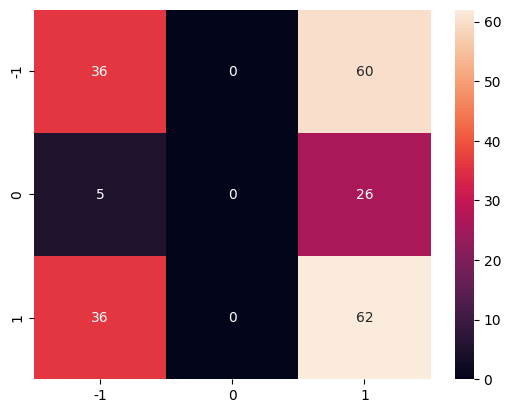

In [250]:
categories = ["-1", "0","1"]
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)

In [251]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.47      0.38      0.42        96
           0       0.00      0.00      0.00        31
           1       0.42      0.63      0.50        98

    accuracy                           0.44       225
   macro avg       0.30      0.34      0.31       225
weighted avg       0.38      0.44      0.40       225



C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### KNN Classifier with Oversampling of 0 :

In [252]:
print("Before OverSampling, counts of label '1': {}".format(np.count_nonzero(y_train == '1'))) 
print("Before OverSampling, counts of label '-1': {}".format(np.count_nonzero(y_train == '-1'))) 
print("Before OverSampling, counts of label '0': {}".format(np.count_nonzero(y_train == '0'))) 
print("Before OverSampling: 675")
oversample = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = oversample.fit_resample(X_train_cv, y_train) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_over.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_over.shape)) 

print("After OverSampling, counts of label '1': {}".format(np.count_nonzero(y_train_over == '1'))) 
print("After OverSampling, counts of label '-1': {}".format(np.count_nonzero(y_train_over == '-1'))) 
print("After OverSampling, counts of label '0': {}".format(np.count_nonzero(y_train_over == '0')))
print("After OverSampling: 849")

Before OverSampling, counts of label '1': 0
Before OverSampling, counts of label '-1': 0
Before OverSampling, counts of label '0': 0
Before OverSampling: 675
After OverSampling, the shape of train_X: (849, 70)
After OverSampling, the shape of train_y: (849,) 

After OverSampling, counts of label '1': 0
After OverSampling, counts of label '-1': 0
After OverSampling, counts of label '0': 0
After OverSampling: 849


In [253]:
knnclf_over = KNeighborsClassifier(n_neighbors = 11) 
knnclf_over.fit(X_train_over, y_train_over)

KNeighborsClassifier(n_neighbors=11)

In [254]:
y_pred=knnclf_over.predict(X_test_cv)

In [255]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test,y_pred))

[[44 34 18]
 [15 12  4]
 [44 34 20]]
0.3377777777777778


<Axes: >

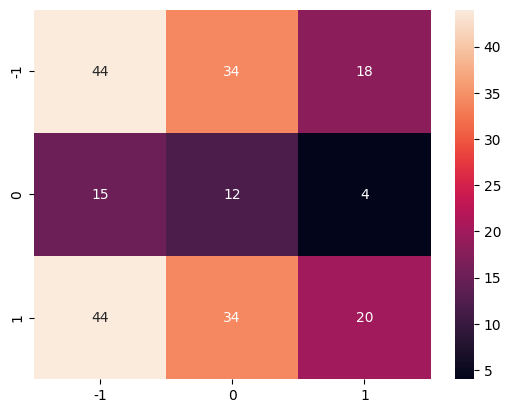

In [256]:
categories = ["-1", "0","1"]
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)

In [257]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.43      0.46      0.44        96
           0       0.15      0.39      0.22        31
           1       0.48      0.20      0.29        98

    accuracy                           0.34       225
   macro avg       0.35      0.35      0.31       225
weighted avg       0.41      0.34      0.34       225



### Logistic Regression :

In [258]:
log_reg_clf=LogisticRegression()
log_reg_clf.fit(X_train_cv, y_train)

LogisticRegression()

In [259]:
y_pred=log_reg_clf.predict(X_test_cv)

In [260]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test,y_pred))

[[42  0 54]
 [ 8  0 23]
 [45  0 53]]
0.4222222222222222


<Axes: >

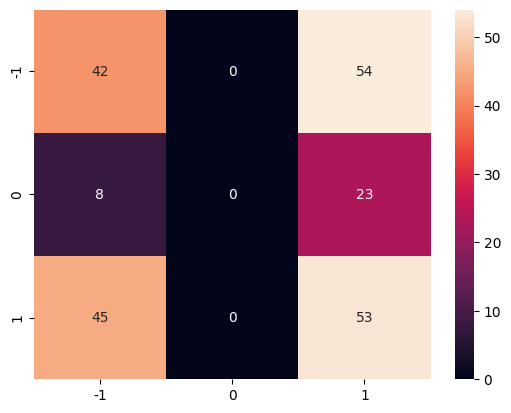

In [261]:
categories = ["-1", "0","1"]
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)

In [262]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.44      0.44      0.44        96
           0       0.00      0.00      0.00        31
           1       0.41      0.54      0.46        98

    accuracy                           0.42       225
   macro avg       0.28      0.33      0.30       225
weighted avg       0.37      0.42      0.39       225



C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Random Forest Classifier :

In [263]:
random_forest_classifier=RandomForestClassifier(n_estimators=100)
random_forest_classifier.fit(X_train_cv,y_train)

RandomForestClassifier()

In [264]:
y_pred=random_forest_classifier.predict(X_test_cv)

In [265]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
print(accuracy_score(y_test,y_pred))

[[42  0 54]
 [ 8  0 23]
 [45  0 53]]
0.4222222222222222


<Axes: >

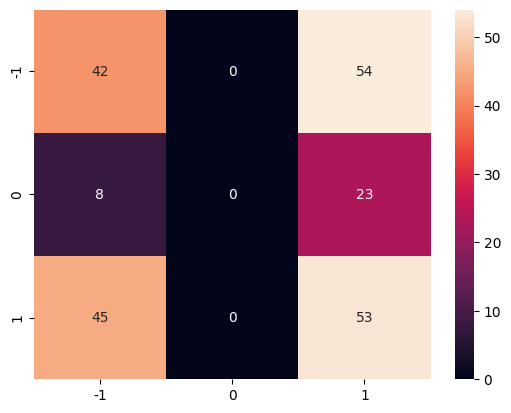

In [266]:
categories = ["-1", "0","1"]
sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories)

In [267]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.44      0.44      0.44        96
           0       0.00      0.00      0.00        31
           1       0.41      0.54      0.46        98

    accuracy                           0.42       225
   macro avg       0.28      0.33      0.30       225
weighted avg       0.37      0.42      0.39       225



C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kasiv\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Analyzing the test data :

In [269]:
analysis_df = pd.DataFrame(X_test_cv.toarray(), columns=cv.get_feature_names_out())
analysis_df['y_test']=y_test
analysis_df['y_pred']=y_pred
analysis_df.to_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\healthcare_reviews\analysis.csv',index=False)

### Reason for low eval metric value :

- Insufficient number of data for training (675) and testing (225)
- Data imbalance for neutral reviews(sentiment - 0)
- Training dataset is not clear. Eg : A Review "I have mixed feelings about my experience." has been categorized in all 3 sentiments (+ve, -ve and neutral)

## EDA :

In [270]:
sentiment_counts = df['Sentiment'].value_counts()

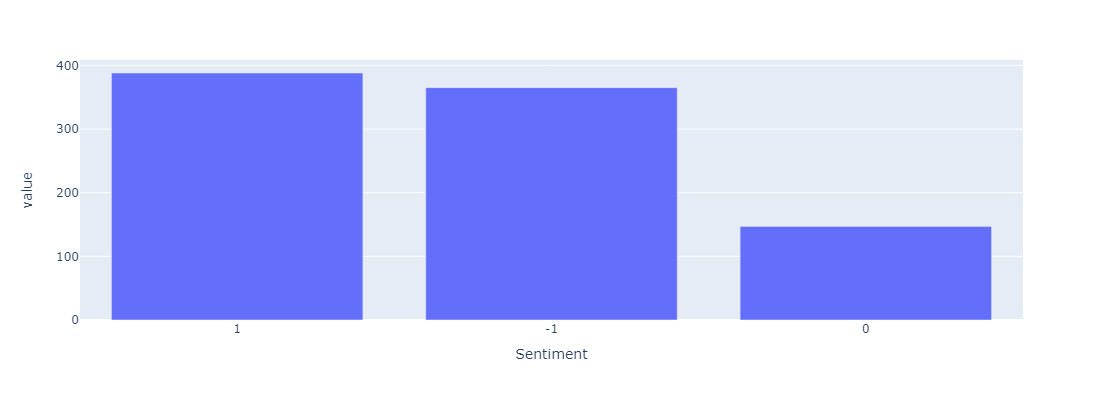

In [271]:
fig = px.bar(sentiment_counts,height=400,width=700)
fig.update_layout(showlegend=False)
fig.show()

In [133]:
cv = CountVectorizer(ngram_range=(1,2))

X_cv = cv.fit_transform(X)

In [134]:
dataset_analysis = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
dataset_analysis['Sentiment']=y

In [136]:
dataset_analysis.to_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\healthcare_reviews\dataset_analysis_2.csv',index=False)

In [137]:
dataset_analysis.shape

(900, 71)

In [209]:
temp_df=dataset_analysis.query("Sentiment=='1'")

In [212]:
positive_df=pd.DataFrame()
positive_df['Words']=list(temp_df.iloc[:, :-1].columns)
positive_df['Frequency']=temp_df.iloc[:, :-1].sum().values
positive_df = positive_df.sort_values(by='Frequency',ascending=False)
positive_df.to_csv(r'positive_df_1.csv',index=False)

In [217]:
positive_df.head()

,Words,Frequency
20,experience,209
60,service,136
41,not,134
50,provider,127
32,healthcare provider,86


In [233]:
positive_df[positive_df['Words'].str.split().apply(len) > 1]

,Words,Frequency
32,healthcare provider,86
16,disappointing not,50
61,service disappointing,50
12,coming back,50
42,not coming,50
18,excellent great,48
29,great experience,48
52,provider excellent,48
34,highly recommended,46
54,received highly,46


In [224]:
temp_df=dataset_analysis.query("Sentiment=='-1'")

In [225]:
negative_df=pd.DataFrame()
negative_df['Words']=list(temp_df.iloc[:, :-1].columns)
negative_df['Frequency']=temp_df.iloc[:, :-1].sum().values
negative_df = negative_df.sort_values(by='Frequency',ascending=False)
negative_df.to_csv(r'negative_df_1.csv',index=False)

In [226]:
negative_df.head()

,Words,Frequency
20,experience,186
60,service,131
41,not,124
50,provider,109
7,bad,80


In [232]:
negative_df[negative_df['Words'].str.split().apply(len) > 1]

,Words,Frequency
32,healthcare provider,73
63,service received,54
54,received highly,54
59,satisfied service,54
34,highly recommended,54
1,attentive could,48
65,staff caring,48
43,not happier,48
10,caring attentive,48
14,could not,48


In [234]:
temp_df=dataset_analysis.query("Sentiment=='0'")

In [236]:
neutral_df=pd.DataFrame()
neutral_df['Words']=list(temp_df.iloc[:, :-1].columns)
neutral_df['Frequency']=temp_df.iloc[:, :-1].sum().values
neutral_df = negative_df.sort_values(by='Frequency',ascending=False)
neutral_df.to_csv(r'neutral_df_1.csv',index=False)

In [237]:
neutral_df.head()

,Words,Frequency
20,experience,87
50,provider,54
41,not,49
60,service,47
31,healthcare,34


In [238]:
neutral_df[neutral_df['Words'].str.split().apply(len) > 1]

,Words,Frequency
32,healthcare provider,34
56,recommend provider,20
69,would not,20
67,terrible would,20
23,experience terrible,20
36,mixed feeling,20
25,feeling experience,20
44,not recommend,20
29,great experience,19
52,provider excellent,19


## Insights from the Analysis :

- Positive Reviews :
  - Experience - 209
  - Service - 139
  - healthcare provider - 86
  - disappointing not - 50
  - coming back - 50  

- Negative Reviews :
  - Experience - 186
  - Service - 131
  - healthcare provider - 73
  - highly recommended - 54 (Wrongly classified)
  - not happier - 48
  - experience terrible	- 36

- Neutral Reviews :
  - experience	- 87
  - terrible would	- 20
  - experience terrible	- 20
  - mixed feeling - 20
  - bad experience	- 15 

Final Thoughts :
  - People are satisifed with the healthcare provider(doctor).
  - They are willing to come back to this hospital.
  - Some people are not happy as they had a terrible experience.
  - Some people have mixed emotions about the healthcare center.